# Introduction to topic modeling with DL

In this exercise, I explore topic modeling with transfer learning applied to NLP. The goal is to show how to leverage pre-trained models in clustering for topic modeling. As we saw before, topic modeling is a form of unsupervised modeling with the goal of clustering similar samples (documents) together to form groups. The groups of documents are then labeled using their properties/attributes. In this particular case, clusters of text documents can be labeledu using by extracting topics from the clusters.

In this exercise, we reproduce/develop a methodology similar to BertTopic and Top2vec that leverages pre-trained embedding DL models.  We use the 20newsgroup dataset which is a benchmark dataset used in text classification to assess the quality of the topic modeling method. Instead of using the labels from the 20 newsdataset, we cluster the samples/documents. We can then compare the clusters to the labeled classes. The general step by step workflow is as follow:

- embedding: BERT/sentence encoding or Universal Sentence Encoder
- dimension reduction: UMAP
- clustering: HDBSCAN
- labeling: cluster tf-idf

We describe in more details the various steps below.

## Embedding

Text must be tokenized: turn words or sentences into a numerical format before performing any modeling.
We used a pre-trained embedding model to convert our text into a vector space. For this exercise, we use Universal Sentence Encoder (USE) from tensforflow hub. The output of the encoder is a 512 dimensional vector space. The 512 vector space correspond to a feature space maps the meanings and semantic relationship between words or sentences in the input corpus dataset it was trained on. Since, USE was trained on a large general text dataset it captures general semantic relationship between words in the language.

## Dimension reduction

The embedding creates a very large encoding of text and this high dimension is often problematic for clustering algorithms. To reduce the dimension of the embedding there are multiple existing methods such as Principal Component Analysis (PCA) or Uniform Manifold Approximation and Projection (UMAP). Recent literature has shown that UMAP works well and has less constraints than PCA. As is done in BerTopic and Top2vec, we use UMAP to reduce the dimension of the feature space.

## Clustering

Text clustering is the process of grouping similar text samples together. There are different algorithms available such as Kmeans and/or DSBCAN. In this exercise, we use HDBSCAN (Hierarchical Density Based Spatial Clustering of Applications with Noise). HDBSCAN is is a variant of DSBCAN that consider multiple spatial scales in the clustering. The algorithm does not require any assumption (spherical cluster like Kmeans for instance) as is robust to outliers/noise.

## Labeling

Once the groups or clusters have beeen create, we have to label each group with a topic based on its characteristic. There are multiple strategies available:
- extract topics using word occurence or tf-idf of clusters
- extract topics based on the closeness to the mean vector or centroid of the clsuters.

We explore cluster tf-idf and centroid based topic vector.

## Dataset

The 20newsgroup dataset is a popular benchmark dataset used in NLP. It was originally used in a publication by Ken Lang published in 1995. It was later made available in kaggle and other repositories. It contains almost 20,000 newsgroup documents labeled as 20 topics.


Useful links:

- twitter sentiment airlines data:

https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

- Universal Sentence Encoder with tensorflow:

https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder
paper: https://arxiv.org/abs/1803.11175

- transformers:

https://towardsdatascience.com/transformers-explained-visually-part-1-overview-of-functionality-95a6dd460452

- BERT: bert paper: https://arxiv.org/abs/1810.04805

- https://towardsdatascience.com/bertopic-what-is-so-special-about-v0-16-64d5eb3783d9

- http://top2vec.rtfd.io
D. Angelov, Top2Vec: Distributed Representations of Topics, (2020), arXiv.org.

- L. McInnes, J. Healy, and J. Melville, UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction, (2020), arXiv.org.

- C. Malzer and M. Baum, A Hybrid Approach To Hierarchical Density-based Cluster Selection, (2021), arXiv.org.https://github.com/lmcinnes/umap
Topic Modeling
Top2vec
Hdbscan
Umap

comparing clustering algorithm:

https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html

https://michael-fuchs-python.netlify.app/2020/06/20/hdbscan/


- https://pnlpuos.github.io/topic-modeling


# Set up environment and load libraries

- load libraries
- install packages and tools
- authenticate to google drive and gcp account

In [1]:
#!pip uninstall tensorflow -y

#!pip install  tensorflow==2.13 #specific version needed for BERT
# A dependency of the preprocessing for BERT inputs
#!pip install -U "tensorflow-text==2.13.*"

In [2]:
#!pip install np_utils

In [3]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 7.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [4]:
###### Library used in this script
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os, glob
import re

#ML imports
import sklearn
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


#Keras import
from tensorflow import keras
#from keras.models import Model
import tensorflow as tf
import tensorflow_hub as hub

from absl import logging

#from tensorflow.keras.utils import np_utils
#import np_utils
sns.set_style('darkgrid')
pd.set_option('display.max_colwidth', None)

In [5]:

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter

import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('display.max_columns', 50)

#Please download the below also. This will resolve your issue:

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

#nltk.download('omw-1.4'*)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
!pip install umap-learn
#https://github.com/MaartenGr/BERTopic/issues/1450
!pip install hdbscan

In [7]:
import umap as umap
import hdbscan

In [8]:
sklearn.__version__

'1.6.1'

In [9]:
#GCP account authentification
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [10]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Functions
In the next part of the script, we declare all the functions used in the sripts.  It is good practice to place functions at the beginning of a script or in an external source file. Here are the 13 functions used:

* **create_dir_and_check_existence**:  create and output directory given a path. The output directory will be the working directory throughout the analysis.


In [11]:
def create_dir_and_check_existence(path):

    #Create a new directory
    try:
        os.makedirs(path)
    except:
        print ("directory already exists")

from matplotlib import pyplot

In [12]:
def clean_text(data):

    import re

    #1. Removing URLS
    data = re.sub('http\S+', '', data).strip()
    data = re.sub('www\S+', '', data).strip()

    #2. Removing Tags
    data = re.sub('#\S+', '', data).strip()

    #3. Removing Mentions
    data = re.sub('@\S+', '', data).strip()

    #4. Removing upper brackets to keep negative auxiliary verbs in text
    data = data.replace("'", "")

    #5. Tokenize
    text_tokens = word_tokenize(data.lower())

    #6. Remove Puncs and number
    tokens_without_punc = [w for w in text_tokens if w.isalpha()]

    #7. Removing Stopwords
    stop_words = stopwords.words('english')
    for i in ["not", "no"]:
            stop_words.remove(i)
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]

    #8. lemma
    text_cleaned = [WordNetLemmatizer().lemmatize(t) for t in tokens_without_sw]


    #joining
    return " ".join(text_cleaned)

In [13]:
#pulled from tensorflow tutorial and more
#https://stackoverflow.com/questions/70854665/tensorflow-textvectorization-convert-the-predicted-text-back-to-a-human-readabl

def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<\b>' ,' ')
  return tf.strings.regex_replace(stripped_html,'[%s#@]' % re.escape(string.punctuation),'')

def normalize(text):
  remove_regex = f'[{re.escape(string.punctuation)}]'
  space_regex = '...'
  result = tf.strings.lower(text)
  result = tf.strings.regex_replace(result, remove_regex, '')
  result = tf.strings.regex_replace(result, space_regex, ' ')
  return result

In [14]:
#Modified from
#https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder

def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(text_corpus,embed):
  message_embeddings_ = embed(text_corpus)
  plot_similarity(text_corpus, message_embeddings_, 90)

# Parameters and Arguments

It is good practice to set all parameters and input arguments at the beginning of the script. This allows for better control and can make modifications of the scripts for other applications easier. Some arguments relate to path directories, input files and general parameters for use in the analyses (e.g. proportion of hold out).


In [15]:
############################################################################
#####  Parameters and argument set up ###########

#ARG 1
in_dir = '/content/gdrive/MyDrive/Colab Notebooks/deep-learning-nlp-intro/topic_modeling_bertopic_top2vec/data'
out_dir = '/content/gdrive/MyDrive/Colab Notebooks/deep-learning-nlp-intro/topic_modeling_bertopic_top2vec/'

out_suffix = 'topic_modeling_dl_2025-03-12'
random_seed= 42
create_out_dir = True

#ARG 7
## Input data
data_dir = '/content/drive/MyDrive/Colab Notebooks/deep-learning-nlp-intro/topic_modeling_bertopic_top2vec/data/'
#ARG 8
run_model = False #if True, model is trained, note this may take several hours.

#ARG 9
# Use pre-trained model if run_model is False
model_path = None


In [16]:
################# START SCRIPT ###############################

######### PART 0: Set up the output dir ################

#set up the working directory
#Create output directory

if create_out_dir==True:
    out_dir_new = "output_data_"+out_suffix
    out_dir = os.path.join(out_dir,"outputs",out_dir_new)
    create_dir_and_check_existence(out_dir)
    os.chdir(out_dir)        #set working directory
else:
    os.chdir(out_dir) #use working dir defined earlier


directory already exists


In [17]:
print(out_dir)

/content/gdrive/MyDrive/Colab Notebooks/deep-learning-nlp-intro/topic_modeling_bertopic_top2vec/outputs/output_data_topic_modeling_dl_2025-03-12


In [18]:
!pwd

/content/gdrive/MyDrive/Colab Notebooks/deep-learning-nlp-intro/topic_modeling_bertopic_top2vec/outputs/output_data_topic_modeling_dl_2025-03-12


#0.Workflow/pipeline

We describe here the modeling pipeline we set up for this exercise:
1. **Load and explore data**
- Obtain data sklearn
- Quick exploration of 20 newsgroups dataset
2. **Embedding**
- Using universal sentence encoder for text vectorization
3. **Dimension reduction**
- exploring UMAP
- reducing dimensions
4. **Clustering**
- exploring HDBSCAN
- performing clustering
5. **Labeling**
- generate labels from cluster word counts
- generate labels from cluster tfidf
6. **Cluster evaluation**
- exploring extrensic and intrisic metrics
- computing evaluation metrics for clustering
7. **Conclusions**
- summarizing results
- future improvements

# 1.Load and explore data

The 20newsgroup dataset is a popular benchmark dataset used in NLP. It is made directly available within the sklearn pacage. It contains almost 20,000 newsgroup documents labeled as 20 topics. For this exercise, we will subset the dataset to four topics to make it easier to interpret outputs from the clustering.

Useful links:

- https://medium.com/@datailm/text-classification-mastery-a-step-by-step-guide-using-the-20-newsgroups-dataset-a0a56fc245e0

- https://dylancastillo.co/clustering-documents-with-openai-langchain-hdbscan/
- https://www.kaggle.com/code/aybukehamideak/clustering-text-documents-using-k-means
- https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py


In [19]:
# Check for GPU
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


In [20]:
import tensorflow as tf
print(tf.__version__) #should use higher tensorflow!!!

2.18.0


In [21]:
keras.__version__

'3.8.0'

To get the dataset, we use sklearn.datasets and impor the relevant dataset using the fetch function. We will ask for the entire data with some cleaning.

In [22]:
from sklearn.datasets import fetch_20newsgroups
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
print(type(newsgroups))
# Create a DataFrame from the dataset
df = pd.DataFrame({'text': newsgroups.data, 'label': newsgroups.target})

# Get labels for the documents
df['label'] = df['label'].map(lambda x: newsgroups.target_names[x])
print(df.shape)
print(df['label'].nunique())
df['label'].value_counts()

<class 'sklearn.utils._bunch.Bunch'>
(18846, 2)
20


,count
label,
rec.sport.hockey,999
soc.religion.christian,997
rec.motorcycles,996
rec.sport.baseball,994
sci.crypt,991
rec.autos,990
sci.med,990
comp.windows.x,988
sci.space,987


Our goal is to better understand topic modeling with Deep Learning so we reduce the complexity of the dataset by selecting only 4 topics from the 20 topics available in the 20newsgroup dataset:

- science-space
- talks-politics
- recreative-sport-baseball
- computer-windows

In [23]:
selected_topics = ['sci.space','talk.politics.misc','rec.sport.baseball','comp.windows.x']
df = df.loc[df['label'].isin(selected_topics)]
print(df['label'].value_counts())
df.shape

label
rec.sport.baseball    994
comp.windows.x        988
sci.space             987
talk.politics.misc    775
Name: count, dtype: int64


(3744, 2)

The subset of 20news groups now contains 3744 rows. It's balanced wtih slighly less documents on the topic 'talk-politcs'. This means that we should in theory have clusters of similar size if we are able to match clusters and classes.

In [24]:
df.head()

,text,label
21,"\nSorry, that's a feature. The ICCCM specifies how the app should set its title, so the wm is obliged to do it. If this bothers you, complain to the app writer.\n\n\nWrite your own wm that doesn't support the ICCCM. Or write an program that you give a window ID and a title. The your program can set the windows title for the app and then if the app changes it, your program switches it back again.\n\n",comp.windows.x
25,"AW&ST had a brief blurb on a Manned Lunar Exploration confernce\nMay 7th at Crystal City Virginia, under the auspices of AIAA.\n\nDoes anyone know more about this? How much, to attend????\n\nAnyone want to go?",sci.space
32,"Has anybody generated an X server for Windows NT? If so, are you willing\nto share your config file and other tricks necessary to make it work?\n\nThanks for any information.",comp.windows.x
33,\nBe patient. He has a sore shoulder from crashing into the wall.\nThe Cards will give him all the time he needs to come around.\nHe is their full time centerfielder.\nHe will not however steal as often this year as he is hitting\nclean-up.,rec.sport.baseball
37,\n\tProof that the entire private sector is vastly more inefficient?\n\n\n\tBlue Cross is the government health insurance provider.\n\n\tOops.\n\n\t[Ads for Z magazine deleted to Save the Earth],talk.politics.misc


#2. **Embedding**

To vectorize the text, we use Universal Sentence Encoder (USE) from tensorflow hub. It is a pre-trained model embedding published in 2018. USE encode sentences but can take input of any size. As a general purpose embedding, it performs well on many NLP tasks when fine tuned.  USE also tries to tackle bias in the data (racial, gender etc.) and performs well on the Word Embedding Association Tests (WEAT).

We use the weights from USE version 4 accessible via this URL:
- "https://tfhub.dev/google/universal-sentence-encoder/4"

The output of the USE embedding layers is 512 feature space.

Useful links:
- https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder

- https://developers.googleblog.com/2018/04/text-embedding-models-contain-bias.html

- https://krishnakshirsagar87.medium.com/text-classification-with-universal-sentence-encoder-b4bb471cc0af


In [25]:
#import tensorflow_hub as hub

tfhub_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
embedding_use = hub.load(tfhub_url) # load Universal Sentence Encoder
embedding_use

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7be900178110>

In [26]:
corpus = [
'@john, I like baseball',
'I love baseball especially batting',
'I use linux rather than windows',
'My os is open source',
'#participate, elections are taking place in two weeks',
'The senate should vote on this motion',
]

In [27]:
embedded_text = embedding_use(corpus)
embedded_text

<tf.Tensor: shape=(6, 512), dtype=float32, numpy=
array([[ 0.01276491, -0.02501938, -0.05928737, ...,  0.01738831,
        -0.0141086 ,  0.03998813],
       [ 0.00096526,  0.02050705, -0.04871426, ..., -0.04666071,
        -0.07232241, -0.04692477],
       [-0.01414567, -0.02852671,  0.01871562, ...,  0.00488818,
        -0.03652943, -0.03138123],
       [-0.03905844, -0.01882505, -0.00536263, ...,  0.01108819,
        -0.05079075, -0.00850757],
       [-0.06950773, -0.07787099,  0.00537366, ...,  0.00710229,
        -0.02744536,  0.02613232],
       [ 0.04325299, -0.06937122, -0.00065101, ..., -0.04975071,
         0.0336398 ,  0.01411583]], dtype=float32)>

Let's compute the inner product wich correspond to the cosine similarity. We find that sentence 1 and sentence 2 are related as expected.

In [28]:
corr = np.inner(embedded_text, embedded_text)
pd.DataFrame(corr)

,0,1,2,3,4,5
0,1.000000,0.585114,0.003104,0.049160,0.028214,0.132847
1,0.585114,1.000000,0.051937,0.049487,0.019841,0.007329
2,0.003104,0.051937,1.000000,0.498492,0.065784,-0.039394
3,0.049160,0.049487,0.498492,1.000000,0.074944,-0.016426
4,0.028214,0.019841,0.065784,0.074944,1.000000,0.198288
5,0.132847,0.007329,-0.039394,-0.016426,0.198288,1.000000


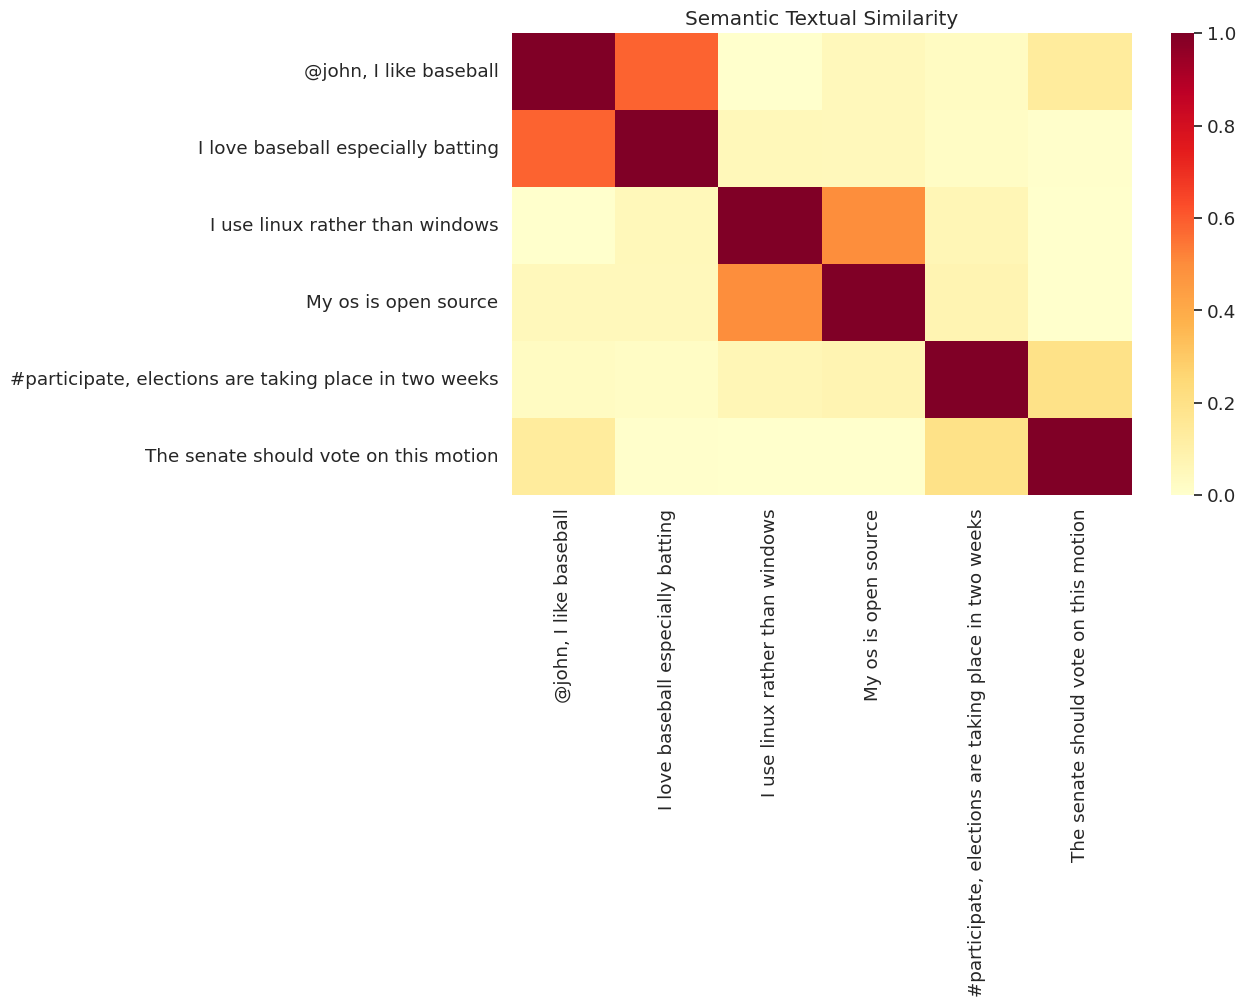

In [29]:
run_and_plot(text_corpus=corpus,
             embed=embedding_use)

The mock up dataset consists in 6 sentences with a variety of length with some unusual characters (# and @). We can see that the sentences that are similar show strong cosine similarity.

Let's now apply this to our dataset.

In [30]:
print(type(df['text'].values[0]))
df['text'].values[0]

<class 'str'>


"\nSorry, that's a feature.  The ICCCM specifies how the app should set its title, so the wm is obliged to do it.  If this bothers you, complain to the app writer.\n\n\nWrite your own wm that doesn't support the ICCCM.  Or write an program that you give a window ID and a title.  The your program can set the windows title for the app and then if the app changes it, your program switches it back again.\n\n"

Let's convert our documents to list of text as input into USE.

In [31]:
list_text = df['text'].to_list()
print(len(list_text))
list_text[1:2]

3744


['AW&ST  had a brief blurb on a Manned Lunar Exploration confernce\nMay 7th  at Crystal City Virginia, under the auspices of AIAA.\n\nDoes anyone know more about this?  How much, to attend????\n\nAnyone want to go?']

We can embedde each document in USE using the instantiated encoding layer. This produces a 3744x512 tensor.

In [32]:
embedded_text = embedding_use(list_text)
embedded_text

<tf.Tensor: shape=(3744, 512), dtype=float32, numpy=
array([[ 0.06064681, -0.03505683, -0.04552798, ...,  0.05488847,
         0.00108737, -0.0111248 ],
       [-0.05406706, -0.02499637,  0.00398008, ..., -0.01830359,
        -0.02077572, -0.03779927],
       [-0.06712257, -0.03160696, -0.06027848, ..., -0.00983679,
         0.04648712, -0.02257958],
       ...,
       [-0.00400411, -0.07042237, -0.04526532, ...,  0.0014028 ,
        -0.00606017,  0.01055343],
       [-0.01874406, -0.03414074,  0.00079914, ...,  0.0614885 ,
        -0.03676056,  0.00904108],
       [-0.00728451, -0.01814894,  0.00287411, ..., -0.03475184,
        -0.04445034, -0.08088386]], dtype=float32)>

#3. **Dimension Reduction: UMAP**

USE embedding produces a 512 feature space which is very large to use in a cluster algorithm.  We use Uniform Manifold Approximation and Projection (UMAP) to reduce the embedding space. UMAP will provide both a way to reduce dimension for data visualization and enhanced clustering of text into different groups.

UMAP is a recent dimension reduction technique published in 2015 that performs well compared to PCA and tSNE. It is non linear in nature and takes into account neighbour structure. It is made available through a python package called UMAP.

When running UMAP, we need to consider the following four major input parameters:

- n_neighbors:
this parameter determines the size of the neighborood to consider in estimating the manifold. Larger values will result in more global structure versus more local structure for lower values. The default value is 15.

- n_components:
number of output dimensions to retain in the UMAP dimension reduction. The default value is 2 but UMAP scales well and one can choose higher dimension embedding if used for clustering rather than visualization.

- min_dist:
this parameters controls how points may be clumped together. It defines a minimum distance between points to be considered in the estimation of the manifold embedding. Lower values will look at closer points and finer structure/detail in the manifold. Larger values will include more far away points and larger/more global structure in the manifold so larger structure in the embedding (dimension reduction). The default value is 0.1.

- metric: distance measurement used in UMAP. UMAP provides a wide range of metrics from Euclidean, Minkowski, cosine, correlation, haversine (for spatial data) etc. The default metric is Euclidean.

Other parameters include the random state to set the randome seed and spread.

Useful links:

- https://github.com/MaartenGr/BERTopic/issues/381
- https://umap-learn.readthedocs.io/en/latest/clustering.html
- https://umap-learn.readthedocs.io/en/latest/parameters.html
- https://www.kdnuggets.com/2020/11/topic-modeling-bert.html
- https://medium.com/@zahraelhamraoui1997/umap-clearly-explained-6324711c855b


In [33]:
#should probably use cosine distance for UMAP!!
print(type(embedded_text))
umap_reducer = umap.UMAP(random_state=random_seed,
                         n_neighbors=15,
                         n_components=5)
data_reduced = umap_reducer.fit(embedded_text).embedding_
print(type(data_reduced))
print(data_reduced.shape)
data_reduced

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
(3744, 5)


array([[ 8.69425  , 12.140133 ,  6.6502943,  6.049452 ,  8.416827 ],
       [ 8.845248 , 10.396988 ,  3.4180741,  1.8914897,  7.7991476],
       [ 8.330103 , 11.535751 ,  5.433918 ,  5.568048 ,  8.186684 ],
       ...,
       [ 7.9158998, 11.92905  ,  6.4707975,  5.968452 ,  8.174281 ],
       [10.325178 ,  9.715884 ,  1.2223693,  2.8380756,  8.851057 ],
       [11.183572 , 12.03622  , -0.5069085,  5.9582047,  7.9878964]],
      dtype=float32)

We only set 3 parameters in our example. It is worth taking a look at all the parameters available in UMAP.

In [34]:
umap_reducer.get_params()

{'a': None,
 'angular_rp_forest': False,
 'b': None,
 'dens_frac': 0.3,
 'dens_lambda': 2.0,
 'dens_var_shift': 0.1,
 'densmap': False,
 'disconnection_distance': None,
 'force_approximation_algorithm': False,
 'init': 'spectral',
 'learning_rate': 1.0,
 'local_connectivity': 1.0,
 'low_memory': True,
 'metric': 'euclidean',
 'metric_kwds': None,
 'min_dist': 0.1,
 'n_components': 5,
 'n_epochs': None,
 'n_jobs': 1,
 'n_neighbors': 15,
 'negative_sample_rate': 5,
 'output_dens': False,
 'output_metric': 'euclidean',
 'output_metric_kwds': None,
 'precomputed_knn': (None, None, None),
 'random_state': 42,
 'repulsion_strength': 1.0,
 'set_op_mix_ratio': 1.0,
 'spread': 1.0,
 'target_metric': 'categorical',
 'target_metric_kwds': None,
 'target_n_neighbors': -1,
 'target_weight': 0.5,
 'tqdm_kwds': {'desc': 'Epochs completed',
  'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]',
  'disable': True},
 'transform_mode': 'embedding',
 'transform_queue_size': 4

In [35]:
'''
#https://github.com/PNLPUOS/PNLPUOS/blob/master/pnlp/notebooks/topic_clustering/topic_clustering_word2vec_13.ipynb

# Perform UMAP dimensionality reduction to more cleanly separate clusters and improve performance.
reducer = umap.UMAP(random_state=42, min_dist=0.0, spread=5, n_neighbors=19)
data_reduced = reducer.fit(data).embedding_
plt.scatter(data_reduced[:, 0], data_reduced[:, 1], marker='.', s=30, lw=0, alpha=0.7, edgecolor='k')
plt.show()
'''

"\n#https://github.com/PNLPUOS/PNLPUOS/blob/master/pnlp/notebooks/topic_clustering/topic_clustering_word2vec_13.ipynb\n\n# Perform UMAP dimensionality reduction to more cleanly separate clusters and improve performance.\nreducer = umap.UMAP(random_state=42, min_dist=0.0, spread=5, n_neighbors=19)\ndata_reduced = reducer.fit(data).embedding_\nplt.scatter(data_reduced[:, 0], data_reduced[:, 1], marker='.', s=30, lw=0, alpha=0.7, edgecolor='k')\nplt.show()\n"

#4. HDBSCAN

HDBSCAN or Hierarchical Density Based Spatial Clustering of Applications with Noise extends DBSCAN adding Hierachical clustering. In the original clustering, a distance is set to create cluster using a spanning tree. In the case of HDBSCAN, we set a number of neighbours and HDBSCAN will automatically generate a hierarchical clustering.

In contrast to KMEANS, we do not need to provide a number of clusters. Clusters are automatically generated base on other input parameters. HDBSCAN (and DBSCAN) also avoids single links linking multiple clusters.

Some of the important parameters in HDBSCAN are:

- min_cluster_size:
the minimum number of points (number_of_neighbours) that cluster must contain to be considered a cluster.  If less than min_cluster_size the group of points are labeled as noise. Default value is 5.
- min_samples:
defines the minimum number of points in a point neighborhood to be considered a core point. This includes the point itself.
- metric:
distance metric used in calculation. The default value is 'Euclidean'.

The general idea of HDBSCAN is create cluster at a variety for spatial scale. The min cluster size will define areas of density at different scale because it does not consider the distance.

Useful links

- https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html
- https://pypi.org/project/hdbscan/

In [36]:

cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean')
cluster.fit(data_reduced)
print(len(cluster.labels_))
unique_elements, counts_elements = np.unique(cluster.labels_, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

3744
Frequency of unique values of the said array:
[[   0    1    2    3]
 [  69   18  861 2796]]


Let's loop through a few iteration of hdbscan with a range of setting for min_cluster_size


In [37]:
list_min_cluster_size = [5, 10, 15, 20, 25]
list_df_cluster = []
for min_cluster_size_val in list_min_cluster_size:
  cluster = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size_val,
                            metric='euclidean')
  cluster.fit(data_reduced)
  print(len(cluster.labels_))
  print(type(cluster.labels_))
  unique_elements, counts_elements = np.unique(cluster.labels_, return_counts=True)
  print("Frequency of unique values of the said array:")
  print(np.asarray((unique_elements, counts_elements)))
  df_cluster=pd.DataFrame({'labels': unique_elements,
                            'counts': counts_elements})
  df_cluster['min_cluster_size']=min_cluster_size_val
  list_df_cluster.append(df_cluster)
df_cluster_all = pd.concat(list_df_cluster)
df_cluster_all

3744
<class 'numpy.ndarray'>
Frequency of unique values of the said array:
[[   0    1    2    3    4]
 [  69   18 2796   15  846]]
3744
<class 'numpy.ndarray'>
Frequency of unique values of the said array:
[[   0    1    2    3    4]
 [  69   18 2796   15  846]]
3744
<class 'numpy.ndarray'>
Frequency of unique values of the said array:
[[   0    1    2    3]
 [  69   18  861 2796]]
3744
<class 'numpy.ndarray'>
Frequency of unique values of the said array:
[[  -1    0    1    2]
 [  18   69  861 2796]]
3744
<class 'numpy.ndarray'>
Frequency of unique values of the said array:
[[  -1    0    1    2]
 [  18   69  861 2796]]


,labels,counts,min_cluster_size
0,0,69,5
1,1,18,5
2,2,2796,5
3,3,15,5
4,4,846,5
0,0,69,10
1,1,18,10
2,2,2796,10
3,3,15,10
4,4,846,10


In [38]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=4,
                          metric='euclidean')
cluster.fit(data_reduced)
print(len(cluster.labels_))
print(type(cluster.labels_))
print('number of clusters', len(unique_elements))
unique_elements, counts_elements = np.unique(cluster.labels_, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

3744
<class 'numpy.ndarray'>
number of clusters 4
Frequency of unique values of the said array:
[[  -1    0    1    2    3    4    5    6    7    8    9   10   11   12
    13   14   15   16   17   18   19   20   21   22   23   24   25   26
    27   28   29   30   31   32   33   34   35   36   37   38   39   40
    41   42   43   44   45   46   47   48   49   50   51   52   53   54
    55   56   57   58   59   60   61   62   63   64   65   66   67   68
    69   70   71   72   73   74   75   76   77   78   79   80   81   82
    83   84   85   86   87   88   89   90   91   92   93   94   95   96
    97   98   99  100  101  102  103  104  105  106  107  108  109  110
   111  112  113  114  115  116  117  118  119]
 [1223   69   18   15  846   25    7    6    9    8   10   10    6   14
     8   12    4    6    8    8   14    9   21    8   11    7    4    5
     6    4   10    5    4    5    7    8    6    7   12    5    6    6
    31   13   23    6    6   23    5    9    7    6    7   17   

In [39]:
df['cluster'] = cluster.labels_
df.head()

,text,label,cluster
21,"\nSorry, that's a feature. The ICCCM specifies how the app should set its title, so the wm is obliged to do it. If this bothers you, complain to the app writer.\n\n\nWrite your own wm that doesn't support the ICCCM. Or write an program that you give a window ID and a title. The your program can set the windows title for the app and then if the app changes it, your program switches it back again.\n\n",comp.windows.x,-1
25,"AW&ST had a brief blurb on a Manned Lunar Exploration confernce\nMay 7th at Crystal City Virginia, under the auspices of AIAA.\n\nDoes anyone know more about this? How much, to attend????\n\nAnyone want to go?",sci.space,-1
32,"Has anybody generated an X server for Windows NT? If so, are you willing\nto share your config file and other tricks necessary to make it work?\n\nThanks for any information.",comp.windows.x,-1
33,\nBe patient. He has a sore shoulder from crashing into the wall.\nThe Cards will give him all the time he needs to come around.\nHe is their full time centerfielder.\nHe will not however steal as often this year as he is hitting\nclean-up.,rec.sport.baseball,3
37,\n\tProof that the entire private sector is vastly more inefficient?\n\n\n\tBlue Cross is the government health insurance provider.\n\n\tOops.\n\n\t[Ads for Z magazine deleted to Save the Earth],talk.politics.misc,58


In [40]:
np.sum(counts_elements==4)

11

Note since we set the min_cluster_size parameters to 4, we get the smaller cluster sizes equal to 4. Here are some other things we can see:

- noise: we have 1221 or 32.6% of documents that are not clustered
- largest cluster: contains 852  (out of 3744) or 22.8% of documents
- smallest clusters: contain 4 documents and we have 7 clusters with 4 documents

In [41]:
df['cluster'].value_counts() #report the proportion of points/documents not clustered

,count
cluster,
-1,1223
3,846
54,73
66,71
0,69
...,...
31,4
67,4
28,4


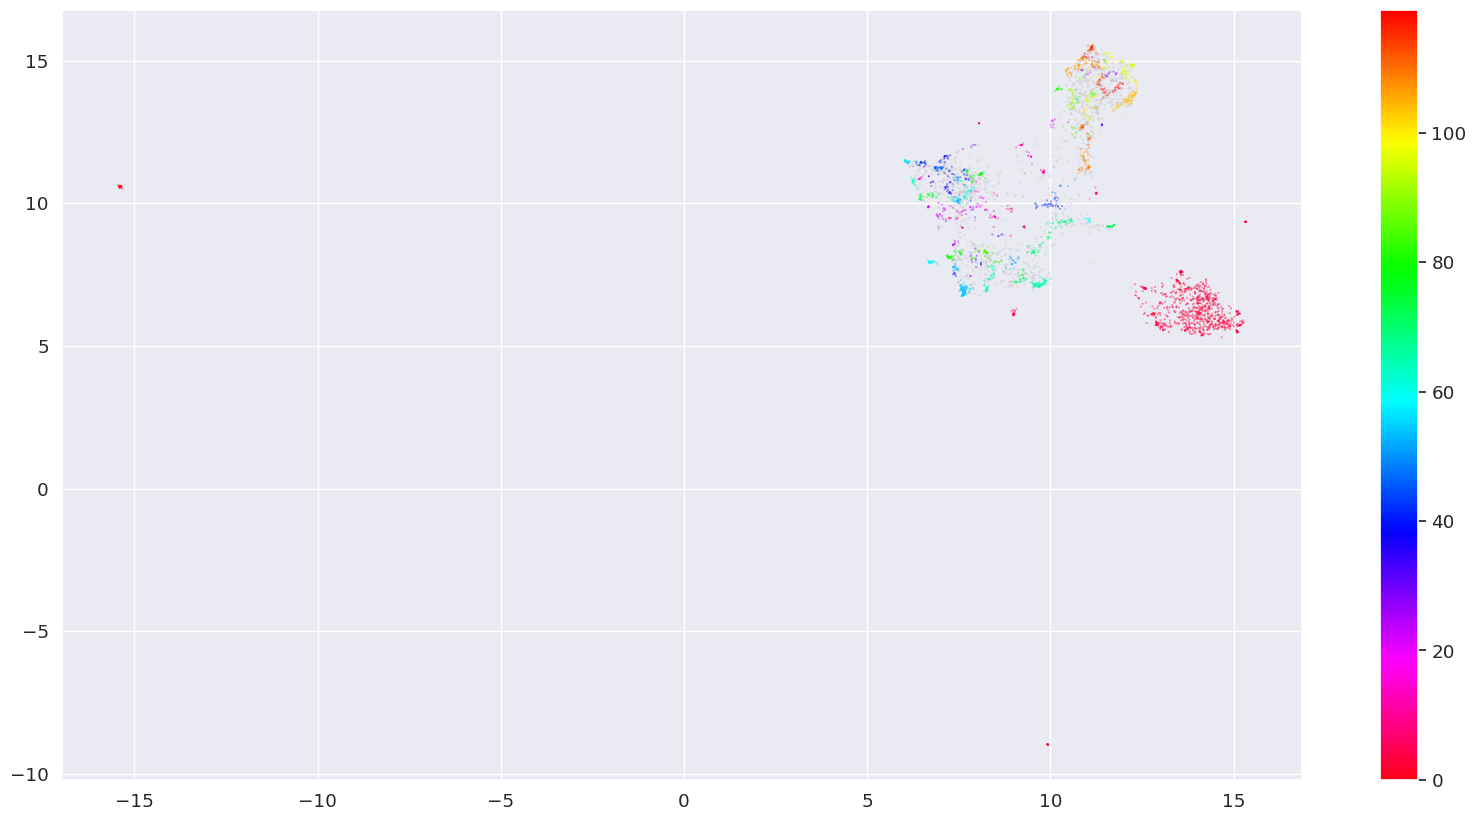

In [42]:

# Prepare data
umap_vis_data = umap.UMAP(n_neighbors=15,
                      n_components=2,
                      min_dist=0.0,
                      metric='cosine').fit_transform(embedded_text)
df_umap_vis = pd.DataFrame(umap_vis_data, columns=['x', 'y'])
df_umap_vis['label'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = df_umap_vis.loc[df_umap_vis.label == -1, :]
clustered = df_umap_vis.loc[df_umap_vis.label != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.label, s=0.05, cmap='hsv_r')
plt.colorbar()

#5. Labeling clusters: Extract topics from clusters

## 5.1 Examining clusters sizes and outliers

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.coherencemodel import CoherenceModel

In [44]:
df

,text,label,cluster
21,"\nSorry, that's a feature. The ICCCM specifies how the app should set its title, so the wm is obliged to do it. If this bothers you, complain to the app writer.\n\n\nWrite your own wm that doesn't support the ICCCM. Or write an program that you give a window ID and a title. The your program can set the windows title for the app and then if the app changes it, your program switches it back again.\n\n",comp.windows.x,-1
25,"AW&ST had a brief blurb on a Manned Lunar Exploration confernce\nMay 7th at Crystal City Virginia, under the auspices of AIAA.\n\nDoes anyone know more about this? How much, to attend????\n\nAnyone want to go?",sci.space,-1
32,"Has anybody generated an X server for Windows NT? If so, are you willing\nto share your config file and other tricks necessary to make it work?\n\nThanks for any information.",comp.windows.x,-1
33,\nBe patient. He has a sore shoulder from crashing into the wall.\nThe Cards will give him all the time he needs to come around.\nHe is their full time centerfielder.\nHe will not however steal as often this year as he is hitting\nclean-up.,rec.sport.baseball,3
37,\n\tProof that the entire private sector is vastly more inefficient?\n\n\n\tBlue Cross is the government health insurance provider.\n\n\tOops.\n\n\t[Ads for Z magazine deleted to Save the Earth],talk.politics.misc,58
...,...,...,...
18808,"Can someone send me ticket ordering information for the\nfollowing teams: Baltimore, Philadelphia and Boston.\n\nAlso, if you have a home schedule available - can you tell me the dates\nfor all home games between July26-Aug6 and between Aug30-Sept10 and if\nany of these games are promotion nights or special discount nights?\n\nThanks !!! Ron\n\nPS: and also who the opponents are for these games :-)\n\nDo NOT reply to this account,\nplease reply to: ronc@vnet.ibm.com",rec.sport.baseball,3
18817,\nWhatever happened to uwm? Is it still available in some form? It's\nbeen years since I used it or heard anyone talk about it.\n--,comp.windows.x,49
18824,"\nYou have to do the same sorts of things that Xt does with its main loop.\nThat is, you have to rig up a timer queue, and you have to put a \nselect(2) or poll(2) call in your main loop. You can obtain the \nfile descriptor of the X display connection using \n fd = ConnectionNumber (display);",comp.windows.x,99
18827,"On 21 Apr 93 00:07:20 GMT, Theodore A. Kaldis observed:\n\n: > because if she heard\n: Thankfully, you got the gender right. For I am not a deviant.\n\nBigots aren't classified as deviants? How sad.\n\n: > how disparaging you are towards political minorities,\n: Sexual deviants do not comprise a ""political minorit[y]"".\n\nSo, what's this I hear about a March on Washington...assuming\nyou are still considering homosexuality and bisexuality\nas subsets of ""sexual deviants?""\n\n: > and if she had any shred of self-respect, she'd be out the door.\n: I only associate with girls who do indeed have self-respect. \n\nI trust that many self-respecting *women* might take some sort\nof offense to your use of the term ""girls"" in the above sentence.\n\n--\nMichael D. Adams (starowl@a2i.rahul.net) Enterprise, Alabama",talk.politics.misc,-1


In [45]:
df['cluster'].value_counts()

,count
cluster,
-1,1223
3,846
54,73
66,71
0,69
...,...
31,4
67,4
28,4


In [46]:
df['label'].value_counts()

,count
label,
rec.sport.baseball,994
comp.windows.x,988
sci.space,987
talk.politics.misc,775


In [47]:
cluster_labels =df['cluster'].unique()
print(cluster_labels)

[ -1   3  58  94  41  50  59 115  96  66  43   9  21 109 117  13  20  89
  54 106 108  72  75  95  25  19 107 110 102  63  60  52  38   2   0 103
  69 111   5 113  23  85  29  12  42  79  62  92  47  73  53  74 114  80
  31  11  87  91  32 104  98   4  16   1  65  77  78  46  61  40  70 100
  68 112  17  82   6  34  39 118  83  48  71  84   7  90  49 101  24  81
  14  22  51  64  93  30  57  33 119  10  99  28   8  35  97  37  55  15
  36  45  18  67  86  56  27  44  26  88 116  76 105]


group all documents/samples into cluster

In [48]:
df.groupby(['cluster'])


In [49]:
df.shape

(3744, 3)

In [50]:
cluster_lookup_df = pd.DataFrame({'labels': cluster_labels,
                              'index_val': np.arange(len(cluster_labels))})
cluster_lookup_df #add counts then you can sort for the relevant index\

cluster_lookup_df =(df.groupby(['cluster'],sort=False)['label'].count()
  .reset_index()
  .set_axis(['cluster', 'count'], axis=1)
  .reset_index(drop=False)
)
cluster_lookup_df.sort_values(by='count',ascending=False)

,index,cluster,count
0,0,-1,1223
1,1,3,846
18,18,54,73
9,9,66,71
34,34,0,69
...,...,...,...
54,54,31,4
111,111,67,4
101,101,28,4
107,107,15,4


## 5.2 Extract topic using word frequency from clusters

In [51]:
df_topic_doc = df.groupby(['cluster'],sort=False).agg({'text': ' '.join})
print(df_topic_doc.shape) #this is probably reordering when doing groupby!!!
print(type(df_topic_doc.head()))
df_topic_doc['label']= cluster_labels
print(cluster_labels[:10])
df_topic_doc.columns

(121, 1)
<class 'pandas.core.frame.DataFrame'>
[ -1   3  58  94  41  50  59 115  96  66]


Index(['text', 'label'], dtype='object')

In [52]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words="english",
                             min_df=3)
vect=vectorizer.fit_transform(df_topic_doc['text'])
print(type(vect))
print(type(vectorizer))

df_example = pd.DataFrame(data=vect.toarray(),
                          columns = vectorizer.get_feature_names_out())
print(df_example.shape)
df_example

<class 'scipy.sparse._csr.csr_matrix'>
<class 'sklearn.feature_extraction.text.CountVectorizer'>
(121, 9742)


,00,000,0060,007,01,015,02,0200,02139,03,030,033,04,0444,05,06,060,067,07,070,077,08,09,0h,0v,...,yellow,yeltsin,yep,yes,yesterday,yield,yo,york,young,younger,youngsters,youth,yuck,yugoslavia,yup,z0,za,zealand,zero,zip,zodiacal,zone,zoo,zoom,zooming
0,70,55,1,0,15,0,14,1,3,3,0,0,24,12,14,6,1,0,7,0,0,6,10,1,1,...,2,0,0,79,9,1,10,22,31,0,0,6,0,2,5,6,6,0,20,4,1,9,3,1,3
1,12,40,0,1,7,2,1,0,0,2,0,0,7,0,11,3,1,0,2,0,1,5,3,0,0,...,1,0,5,50,16,0,0,57,49,9,2,0,1,0,4,0,0,0,9,3,0,22,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,22,0,3,0,4,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0
3,56,6,6,0,13,0,5,2,1,8,3,0,9,2,9,6,0,1,5,0,0,1,4,1,1,...,0,0,0,10,0,2,3,2,8,0,0,0,0,0,0,2,2,0,1,4,0,0,0,3,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
117,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
118,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0
119,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [53]:
df_topic_doc= df_topic_doc.merge(cluster_lookup_df,left_on='label',right_on='cluster')
print(df_topic_doc.shape)
df_topic_doc.columns

(121, 5)


Index(['text', 'label', 'index', 'cluster', 'count'], dtype='object')

Cluster number 3: About baseball

In [54]:
df_example.iloc[1].sort_values(ascending=False)[:20]

,1
year,481
game,415
team,314
think,306
don,305
good,290
games,263
time,253
like,251
just,246


Cluster 35: is about sexuality

In [55]:
df_example.iloc[9].sort_values(ascending=False)[:20] #this is the largest cluster!

,9
men,125
sex,93
kinsey,87
homosexual,86
gay,81
sexual,66
people,49
male,41
partners,35
homosexuals,35


politics for cluster 36

In [56]:
df_example.iloc[17].sort_values(ascending=False)[:20]

,17
andrew,39
demo,21
conference,13
objects,13
applications,12
new,12
interface,11
use,11
windows,11
version,10


## 5.3 Labeling: Extract topic using cluster tf idf

Rather than looking at frequency of words for each cluster (from the combined text of the original documents), we will look at the importance/relevance of words in differentiating between clusters using tf idf.

Let's first look at the original tf idf definition

### TFidf

Let's a quick look at the mathematical formulation of TFIDF:

$$TF(t,d) = \frac{count(t,d)}{count(*,d)}$$

$$IDF(t,D) = log_e(\frac{D}{amount(t,D)})$$

$$TF\text{-}IDF = TF(t,d)*IDF(t,D)$$

- D: number of documents
- count(t,d): number of times term 't' appears in document 'd'
- count(*,d): total number of terms in document 'd'

- amount(t,D): number of document containing 't' accross all D documents

So TF is how frequent the term to the document
and IDF is how frequent is the term across documents.

### Class TFidf

We can consider the following:

- t: frequency for each word in cluster/class
- w: total number of words per cluster/class
- m: number of original documents (before merging into one doc cluster)
- n: number of clusters/classes

We have two main components:

- tf  : frequency of each word in a cluster/class divided by w (total number of words in corpus)
- idf : number of docs in the corpus divided by sum of frequency t of words.

Where the frequency of each word t is extracted for each class i and divided by the total number of words w. This action can be seen as a form of regularization of frequent words in the class. Next, the total, unjoined, number of documents m is divided by the total frequency of word t across all classes n.



In [57]:
#function modified from
#https://www.kdnuggets.com/2020/11/topic-modeling-bert.html
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range,
                            stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

#tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

#function modified from
#https://www.kdnuggets.com/2020/11/topic-modeling-bert.html
def extract_top_n_words_per_topic(tf_idf, count, df_topic_doc, n=20):
    words = count.get_feature_names_out()
    labels = list(df_topic_doc.cluster)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

#function modified from
#https://www.kdnuggets.com/2020/11/topic-modeling-bert.html
def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['cluster'])
                     .text
                     .count()
                     .reset_index()
                     .rename({"cluster": "Topic", "text": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

In [58]:
tf_idf, count = c_tf_idf(documents = df_topic_doc['text'].values,
                         m=sum(df_topic_doc['count']))
print(type(count))
print(type(tf_idf))

<class 'sklearn.feature_extraction.text.CountVectorizer'>
<class 'numpy.ndarray'>


In [59]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, df_topic_doc, n=20)
topic_sizes = extract_topic_sizes(df);
topic_sizes.head(10)

,Topic,Size
0,-1,1223
4,3,846
55,54,73
67,66,71
1,0,69
105,104,49
109,108,45
62,61,41
69,68,37
70,69,34


Cluster number 35: using c-tf-idf is sexuality too

In [60]:
top_n_words[35]

[('beacons', 0.09300795330013624),
 ('navigation', 0.06170564253989962),
 ('otv', 0.059320365402984895),
 ('isp', 0.05331041875073104),
 ('beacon', 0.05228917855717858),
 ('spacecraft', 0.04756843186312417),
 ('turn', 0.0446064969379244),
 ('sarsat', 0.04355354137015917),
 ('sarsats', 0.04355354137015917),
 ('refueling', 0.04355354137015917),
 ('xenon', 0.04120981242155707),
 ('clutter', 0.04120981242155707),
 ('radio', 0.03967767967630915),
 ('crafts', 0.039546910268656595),
 ('radiation', 0.03833451457653609),
 ('dragless', 0.03554027916715403),
 ('payload', 0.03475493178400037),
 ('parachute', 0.03425043204973084),
 ('tether', 0.03425043204973084),
 ('pain', 0.03369950615490816)]

Cluster number 3: using c-tf-idf is baseball too

In [61]:
top_n_words[3]

[('game', 0.01579919354307745),
 ('team', 0.012656522338455536),
 ('year', 0.012222899473077248),
 ('games', 0.012071056674748747),
 ('baseball', 0.011620433140583742),
 ('hit', 0.011168010098677565),
 ('players', 0.010952453170776968),
 ('season', 0.009086868803281302),
 ('runs', 0.009009441206459882),
 ('player', 0.008576384470756983),
 ('league', 0.008374727321711174),
 ('pitching', 0.008310497247129659),
 ('good', 0.00819015619301768),
 ('better', 0.007857890864167742),
 ('play', 0.007693177269035703),
 ('pitcher', 0.00760812506541694),
 ('average', 0.007541569445061826),
 ('win', 0.007530845462273734),
 ('braves', 0.007436272611736581),
 ('ball', 0.007350151247762924)]

Cluster number 36: using c-tf-idf is about politics and police

In [62]:
top_n_words[36]

[('lunar', 0.0191037874240336),
 ('propulsion', 0.017322158723972022),
 ('space', 0.0172912147947356),
 ('telescope', 0.015047891764490713),
 ('nasa', 0.015032746913819535),
 ('faq', 0.012853380784241137),
 ('satellite', 0.012467145106780578),
 ('planetary', 0.011795244125584421),
 ('observatory', 0.011232174743255456),
 ('astronomical', 0.010349419321791946),
 ('models', 0.009924085093324011),
 ('thu', 0.009263803398998675),
 ('fusion', 0.009263803398998675),
 ('rocket', 0.009008892830539553),
 ('mars', 0.008954712330843877),
 ('tele', 0.008526571965475557),
 ('prefix', 0.008436230399527919),
 ('shuttle', 0.008285889215734298),
 ('solar', 0.008275313986824073),
 ('astronomy', 0.00800595527698417)]

#6. Cluster evaluation

To evaluate the cluster we will make use of intrinsic and extrinsic metrics.
Intrinsic metrics measure the quality of the cluster without reference labels while extrinsic metrics require ground truth labels.

We will use 7 different metrics:

- adjusted rand index: ARI measures the similarity between clusters and labels regardless of permutation differences. It is proportional to number of pairs found in the cluster and labels. It is normalized to take into account the effect of randonmoness. It is an extrinsic measure but note also that the labels form clusters and classes can be reversed and the results are the same. It can be used to compare clusters too.

- adjusted mutual information: it meausures the agreement between cluster assignments. Is the mutual information metric normalized for randomness. Mutual information

- homogeneity: purity of a cluster referring to cluster containing only one class. It is an extrinsic measure bounded between 0 and 1 (higher being better).

- completeness: all elements from a particular class are assigned to the same cluster. It is an extrinsic measure bounded between 0 and 1 (higher being better).

- v-measure: is the harmonic mean of homogeneity and completeness. It is not normalized for randomness. This means that random labeling won't result in a zero score especially when the number of clusters is large.

- silhouette_score


Useful links:

- https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation

- https://towardsdatascience.com/7-evaluation-metrics-for-clustering-algorithms-bdc537ff54d2

- https://towardsdatascience.com/performance-metrics-in-machine-learning-part-3-clustering-d69550662dc6

In [63]:
df.head()

,text,label,cluster
21,"\nSorry, that's a feature. The ICCCM specifies how the app should set its title, so the wm is obliged to do it. If this bothers you, complain to the app writer.\n\n\nWrite your own wm that doesn't support the ICCCM. Or write an program that you give a window ID and a title. The your program can set the windows title for the app and then if the app changes it, your program switches it back again.\n\n",comp.windows.x,-1
25,"AW&ST had a brief blurb on a Manned Lunar Exploration confernce\nMay 7th at Crystal City Virginia, under the auspices of AIAA.\n\nDoes anyone know more about this? How much, to attend????\n\nAnyone want to go?",sci.space,-1
32,"Has anybody generated an X server for Windows NT? If so, are you willing\nto share your config file and other tricks necessary to make it work?\n\nThanks for any information.",comp.windows.x,-1
33,\nBe patient. He has a sore shoulder from crashing into the wall.\nThe Cards will give him all the time he needs to come around.\nHe is their full time centerfielder.\nHe will not however steal as often this year as he is hitting\nclean-up.,rec.sport.baseball,3
37,\n\tProof that the entire private sector is vastly more inefficient?\n\n\n\tBlue Cross is the government health insurance provider.\n\n\tOops.\n\n\t[Ads for Z magazine deleted to Save the Earth],talk.politics.misc,58


In [64]:
print(df.dtypes)
df['label_int'] = df['label'].replace({'rec.sport.baseball': 0,
                     'comp.windows.x': 1,
                     'sci.space': 2,
                     'talk.politics.misc':3})
labels_true = df['label_int']
labels_pred = df['cluster'] #cluster_labels
print(df.dtypes)

text       object
label      object
cluster     int64
dtype: object
text         object
label        object
cluster       int64
label_int     int64
dtype: object


In [65]:
#from sklearn import metrics

ari = metrics.adjusted_rand_score(labels_true, labels_pred)
ami =metrics.adjusted_mutual_info_score(labels_true, labels_pred)
homogeneity = metrics.homogeneity_score(labels_true, labels_pred)
completeness = metrics.completeness_score(labels_true, labels_pred)
v_measure = metrics.v_measure_score(labels_true, labels_pred)
fmi =metrics.fowlkes_mallows_score(labels_true, labels_pred)
#metrics.silhouette_score(X, labels, metric='euclidean')# need to figure out this one

metrics_df = pd.DataFrame({'ari':ari,
              'ami':ami,
              'homogeneity':homogeneity,
              'completeness':completeness,
              'v_measure':v_measure,
              'fmi':fmi},index=[0])
metrics_df

,ari,ami,homogeneity,completeness,v_measure,fmi
0,0.269535,0.355227,0.597587,0.269129,0.37112,0.423465


We can see that the ARI and AMI indices are low which suggest that the match between cluster and labels is not strong. We would need to review the algorithm hyperparameters and data cleaning to see if we could improve the results.

#7.Conclusions







In this exercise/lab, we produced a clustering using the Universal Sentence Encoder and HDBSCAN with dimension reduction using UMAP. The methodological steps are similar to what is done in Top2Vec and Bertopic. The cluster topics where generated using TFidf and word count vectorization.

We used 20newsgroup as a dataset because we have existing labels that can help us to validate the topic modeling methodology and results. We use a variety of indices such as Ajusted Rand Index and Adjusted Mutual Information to evaluate the cluster.

The overall workflow is fully automatable (in a function) but can be improved further by:

- merging similar topics using cosine similarity for clusters based on topic labels extracted. A similar methodology is adopted in Top2vec. This is very useful since we do not control the number of clusters from HDBSCAN (we can of course vary some of the parameters) and we can merge similar topics in succession.

- better understand how to tune the hyperparameters such as the ouptut dimension of umap and the setting in HDBSCAN (in particular min_cluster_size).

- cleaning some of the text data or providing better screening of non-sensical words and typos.

## Future modifications and improvements

It would make sense to create a general function that can call all the functions we wrote or modified in this lab into one function. This function could generate cluster ID and provide diagnostic as well a potential labels (extracted from c-TFidf). This function could then compared to the BERTopic algorithm provided in the package. We will be adding this improvement in later iterations of this lab/exercise.

#8. References

- HDBSCAN paper:
R.J.G.B. Campello, D. Moulavi, A. Zimek and J. Sander Hierarchical Density Estimates for Data Clustering, Visualization, and Outlier Detection, ACM Trans. on Knowledge Discovery from Data, Vol 10, 1 (July 2015), 1-51.

- HDBSCAN implemenation paper: hdbscan: Hierarchical density based clustering from journal of open source software. (2017)
https://joss.theoj.org/papers/10.21105/joss.00205

In [66]:
############################# END OF SCRIPT ###################################